# Case Study 3: Helixir Data

In this study, we use richer DeFi data with more attributes. This allows
the influence of individual attributes to be explored. We will focus on
the impact of prices relative to other features.

## Intro

### Instalations

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..')))

# !python -m pip install git+https://github.com/JakRys/finclust
# !pip install yfinance
# !pip install scikit-learn-extra

### Imports

In [2]:
## Import the required modules
import pandas as pd
import matplotlib.pyplot as plt

from finclust.visualization import CumulativeReturnsVisualizator
from datetime import timedelta
import numpy as np

from finclust import PortfolioManager
from finclust.clustering import ScikitClusterer
from finclust.evaluation import QuantstatsEvaluator

from sklearn.metrics.pairwise import nan_euclidean_distances

from sklearn_extra.cluster import KMedoids

import warnings
warnings.filterwarnings('ignore')

## Get Data

We use data from the Helixir data source. This data includes not only
prices and volumes but also active address counts and swap counts.
The data contains the values of the largest capitalization tokens from
the Binance blockchain. We use about 20 of them. The data frequency
is daily. The data are available from 4 June 2021 to 1 December 2022.

Note that during the chosen period, most assets, not excluding cryptocurrencies, experienced a long-term decline. Therefore, the values at the end of the period are lower than at the beginning for most assets.


For clarity, the data has been downloaded and converted to the required format off this notebook.
You can download them from [Helixir](https://helixir.io/helixir-api), for example, using the [pyhelixir-client library](https://github.com/HelixirLabs/pyhelixir-client).

In [3]:
filename = "data/BSC-tokens.csv"

data = pd.read_csv(filename, index_col=0, header=[0, 1])
data.index = pd.to_datetime(data.index)
data

Close                                               \
                     RRB  BabyShibaInu        DOT      HERO      MBOX   
2021-06-04           NaN           NaN  25.104541       NaN  0.883827   
2021-06-05           NaN           NaN  23.914064       NaN  0.842799   
2021-06-06           NaN           NaN  24.121164       NaN  0.749151   
2021-06-07           NaN           NaN  21.584078       NaN  0.757565   
2021-06-08           NaN           NaN  21.764684       NaN  0.810875   
...                  ...           ...        ...       ...       ...   
2022-11-26  1.027584e-07  5.061839e-09   5.300263  0.004031  0.486767   
2022-11-27           NaN  4.971824e-09   5.293689  0.003970  0.471845   
2022-11-28           NaN  4.729176e-09   5.111002  0.003822  0.456746   
2022-11-29  9.958297e-08  4.774302e-09   5.326361  0.003800  0.459973   
2022-11-30  9.505718e-08  4.839928e-09   5.487678  0.003912  0.477209   

                                                                 ...  \
                 BSW      TUSD      USDC     GUARD          ETH  ...   
2021-06-04  0.864310  0.993502  1.002400       NaN  2689.124767  ...   
2021-06-05  0.996651  1.011655  0.996866       NaN  2629.569705  ...   
2021-06-06  1.252391  0.982660  1.008941       NaN  2714.204312  ...   
2021-06-07  1.246153  0.956115  1.004257       NaN  2585.713189  ...   
2021-06-08  1.336266  1.022878  1.005616       NaN  2519.692989  ...   
...              ...       ...       ...       ...          ...  ...   
2022-11-26  0.213690  1.018847  0.999824  0.310241  1205.077597  ...   
2022-11-27  0.209963  0.994773  1.000276  0.312937  1192.494032  ...   
2022-11-28  0.202168  0.983241  0.999763  0.301840  1169.913705  ...   
2022-11-29  0.205567  0.954070  1.002739  0.297795  1217.204874  ...   
2022-11-30  0.216543  0.982886  0.999685  0.299156  1294.558287  ...   

           Addresses                                                     
            ELEPHANT BTT  JF VALK CBET OSK    SFP     USDT     TRX ADMC  
2021-06-04      37.0 NaN NaN  NaN  NaN NaN  334.0  38251.0   931.0  NaN  
2021-06-05       NaN NaN NaN  NaN  NaN NaN  637.0  65551.0  1736.0  NaN  
2021-06-06       NaN NaN NaN  NaN  NaN NaN  883.0  79123.0  2121.0  NaN  
2021-06-07       NaN NaN NaN  NaN  NaN NaN    NaN  84097.0  1837.0  NaN  
2021-06-08      44.0 NaN NaN  NaN  NaN NaN  608.0  72206.0  1737.0  NaN  
...              ...  ..  ..  ...  ...  ..    ...      ...     ...  ...  
2022-11-26       NaN NaN NaN  NaN  NaN NaN    NaN      NaN     NaN  NaN  
2022-11-27       NaN NaN NaN  NaN  NaN NaN    NaN      NaN     NaN  NaN  
2022-11-28       NaN NaN NaN  NaN  NaN NaN    NaN      NaN     NaN  NaN  
2022-11-29       NaN NaN NaN  NaN  NaN NaN    NaN      NaN     NaN  NaN  
2022-11-30       NaN NaN NaN  NaN  NaN NaN    NaN      NaN     NaN  NaN  

[531 rows x 180 columns]

We use only few selected tokens.

In [5]:
symbols_to_drop = ['BabyShibaInu', 'GUARD', 'EGC', 'AFP', 'RACA', 'TIME', 'BNX', 'BabyDoge', 'LUCA', 'SQUA', 'ELEPHANT', 'CBET', 'RRB', 'MBOX', 'BSW', 'USDC', 'BTT', 'JF', 'VALK', 'OSK', 'SFP', 'ADMC']

data = data.swaplevel(axis=1)
data = data.drop(columns=symbols_to_drop)

data = data.swaplevel(axis=1)
data.columns = data.columns.remove_unused_levels()

print(len(data["Close"].columns))
data["Close"].columns

23


Index(['DOT', 'HERO', 'TUSD', 'ETH', 'ASS', 'FIST', 'DEBT', 'WBNB', 'BTCB',
       'BUSD', 'MEER', 'SFM', 'DOGE', 'SFUND', 'XRP', 'LINK', 'Cake', 'NMX',
       'UNI', 'ADA', 'DAI', 'USDT', 'TRX'],
      dtype='object')

In [6]:
tmp_data = data.copy()
tmp_data["Close"] = tmp_data["Close"].fillna(method="ffill").fillna(method="bfill")
tmp_data["Volume"] = tmp_data["Volume"].fillna(0)
tmp_data["Swaps"] = tmp_data["Swaps"].fillna(0)
tmp_data["Addresses"] = tmp_data["Addresses"].fillna(0)

## Set Hyperparameters

Since cryptocurrencies are very volatile, we will rebalance the portfolio
weekly so that we will set the `step` parameter to 1 week. The `window`
parameter is set to 8 weeks. In this study, the parameter of `weights` is
crucial. For the first case, the `weights` for all parameters except prices
will be zero. In the second case, on the contrary, we set the price to
zero weight. The _euclidian distance_ is used as an `affinity function`. To
select the portfolio, we use `K-Medoids` from _scikit-learn-extra_ package.
The algorithm is not deterministic; for reproducibility purposes, we
use a fixed random state. This method is wrapped in ScikitClusterer.
For evaluation, we use `QuantstatsEvaluator`.

In [7]:
## Create instance of PortfolioManager
mgr_base = PortfolioManager(
    window = timedelta(weeks=8),
    step = timedelta(weeks=1),
    weights = {
        "Close": 0,
        "Addresses": 1,
        "Swaps": 1,
        "Volume": 1,
    },
    affinity_func = nan_euclidean_distances,
    clusterer = ScikitClusterer(
        cluster_method = KMedoids(metric = "precomputed", random_state=42),
    ),
    evaluator = QuantstatsEvaluator(as_pct=True),
)
mgr_base.data = tmp_data

## Run

Firstly, we set the appropriate weights to the instances of _PortfolioManager_.

In [ ]:
mgr = mgr_base.copy()
mgr.weights = {
    "Close": 0,
    "Addresses": 1,
    "Swaps": 1,
    "Volume": 0,
}

mgr_price = mgr_base.copy()
mgr_price.weights = {
    "Close": 1,
    "Addresses": 0,
    "Swaps": 0,
    "Volume": 0,
}

Then, we run the proces.

In [8]:
print("Using only price")
display(mgr_price.run())
print("* "*50)
print("Using swaps and addresses")
mgr.run()


Using only price
16:40:21.514 Calculating returns
16:40:21.517 Calculating affinities
16:40:21.776 Composing affinities
16:40:21.916 Calculating clusters
16:40:23.249 Calculating returns of portfolios
16:40:23.923 Evaluating baseline
16:40:24.190 Evaluating cluster portfolios
16:40:25.607 Run completed.
____________________________________
Duration of the run: 0:00:04.093045.



,Baseline,KMedoids-0,KMedoids-1,KMedoids-2,KMedoids-3,KMedoids-4,KMedoids-5,KMedoids-6,KMedoids-7
Start Period,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30
End Period,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30
Risk-Free Rate,0,0,0,0,0,0,0,0,0
Time in Market,100.0,97.0,81.0,59.0,34.0,31.0,44.0,37.0,28.0
Cumulative Return,-52.59,-65.55,-35.82,-77.45,8.16,-64.35,-39.64,-44.72,-0.14
CAGR﹪,-42.77,-54.93,-28.23,-67.18,6.04,-53.76,-31.45,-35.81,-0.11
Sharpe,-0.32,-0.15,-0.19,-1.13,0.29,-1.29,-0.15,-0.69,0.18
Prob. Sharpe Ratio,33.04,41.8,39.84,4.94,65.4,2.25,42.16,17.48,59.69
Sortino,-0.45,-0.19,-0.26,-1.39,0.42,-1.49,-0.24,-0.95,0.24
Sortino/√2,-0.32,-0.14,-0.18,-0.99,0.3,-1.05,-0.17,-0.67,0.17


* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Using swaps and addresses
16:40:25.614 Calculating returns
16:40:25.616 Calculating affinities
16:40:25.873 Composing affinities
16:40:25.998 Calculating clusters
16:40:27.005 Calculating returns of portfolios
16:40:27.648 Evaluating baseline
16:40:27.812 Evaluating cluster portfolios
16:40:29.078 Run completed.
____________________________________
Duration of the run: 0:00:03.463669.



,Baseline,KMedoids-0,KMedoids-1,KMedoids-2,KMedoids-3,KMedoids-4,KMedoids-5,KMedoids-6,KMedoids-7
Start Period,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30,2021-07-30
End Period,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30,2022-11-30
Risk-Free Rate,0,0,0,0,0,0,0,0,0
Time in Market,100.0,100.0,77.0,66.0,44.0,35.0,38.0,35.0,29.0
Cumulative Return,-52.59,156.07,-38.45,-72.42,-14.35,68.62,17.84,-29.04,-15.4
CAGR﹪,-42.77,102.04,-30.44,-61.85,-10.94,47.81,13.06,-22.63,-11.76
Sharpe,-0.32,1.03,-0.25,-0.64,0.01,0.93,0.42,-0.24,-0.02
Prob. Sharpe Ratio,33.04,93.14,36.6,20.29,50.77,90.56,71.98,37.31,49.01
Sortino,-0.45,1.79,-0.36,-0.93,0.02,1.51,0.65,-0.34,-0.02
Sortino/√2,-0.32,1.26,-0.26,-0.66,0.01,1.07,0.46,-0.24,-0.02


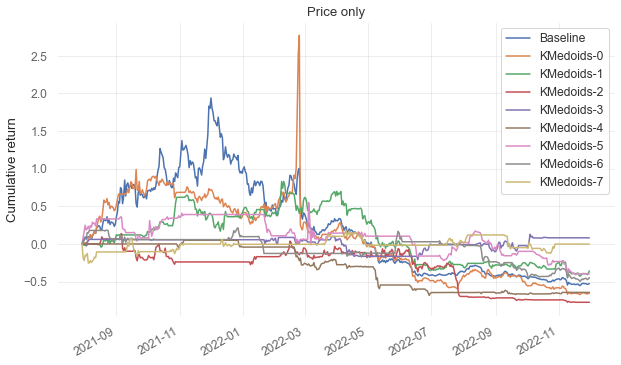

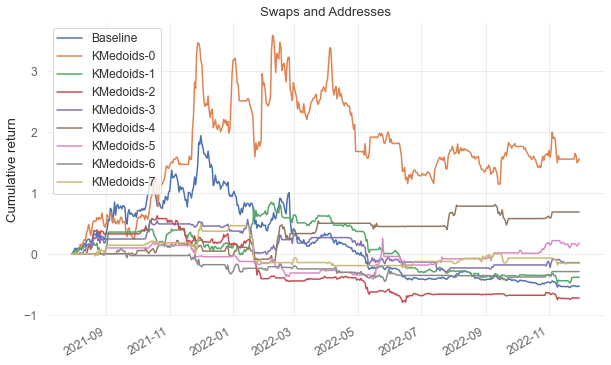

In [9]:
visualizator = CumulativeReturnsVisualizator(
    figsize=(10, 6),
)

visualizator.visualize(mgr_price)
plt.title("Price only")
# plt.title("")
# plt.savefig("outputs/cumret_CS3_Helixir-price.pdf")

visualizator.visualize(mgr)
plt.title("Swaps and Addresses")
# plt.title("")
# plt.savefig("outputs/cumret_CS3_Helixir-others.pdf")
plt.show()

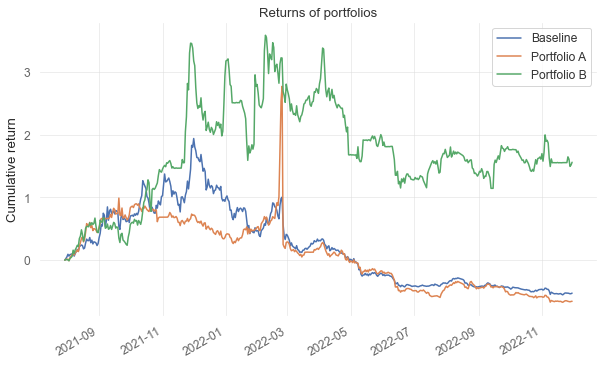

In [10]:
tmp_pm = PortfolioManager()
tmp_pm.portfolios_returns = pd.DataFrame({
    "Baseline": mgr.baseline_returns["Baseline"],
    "Portfolio A": mgr_price.portfolios_returns["KMedoids-0"],
    "Portfolio B": mgr.portfolios_returns["KMedoids-0"],
})
visualizator.visualize(tmp_pm)
# plt.title("")
# plt.savefig("outputs/cumret_CS3_Helixir-joined.pdf")
plt.show()

We found a portfolio $B$ whose cumulative return **outperformed** the performance of portfolio $A$.

The drawdown values are not so informative, as the largest one lasts until the end of the tested period.
In other metrics, portfolio $B$ outperformed portfolio $A$.

Let us see what the results show. Portfolio $B$ is created on _swap_ and _address_ attributes. It shows that these attributes carry essential information related to price evolution.